[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/AI-og-helse/blob/main/uke03-dyplæring/02a_cnn_bildeklassifikasjon.ipynb)

# 🌸 02a: CNN Bildeklassifikasjon - Miljøoppsett og Arkitektur

**Fra Natur til Medisin: En Praktisk Introduksjon til Konvolusjonelle Nevrale Nettverk**

---

## 🎯 Mål for denne delen

I denne notebooken skal vi:
- **Forstå** hvordan CNN fungerer på bilder
- **Sette opp** miljøet for trening (CPU, GPU, MPS)
- **Utforske** blomsterdatasettet
- **Bygge** en CNN-modell fra bunnen av
- **Forberede** for trening i del 2

## �� Teoretisk Fundament

### Formalismen y ~ f(X, θ)

I maskinlæring kan vi uttrykke klassifikasjonsproblemet som:

**y = f(X, θ) + ε**

Hvor:
- **y** = predikert klasse (blomstertype)
- **X** = input bilde (pikselverdier)
- **θ** = modellparametere (CNN-vekter)
- **f** = ikke-lineær funksjon (CNN-arkitekturen)
- **ε** = feilterm (noise)

Dette er identisk med medisinsk bildeanalyse, bare med forskjellige klasser!

## �� Sammenligning: Naturlige vs Medisinske Bilder

| Aspekt | Blomsterklassifikasjon | Medisinsk Bildeanalyse |
|--------|------------------------|------------------------|
| **Input (X)** | RGB-bilder av blomster | MRI, røntgen, CT-scan |
| **Klasser (y)** | Blomstertyper | Sykdomstilstander |
| **Kompleksitet** | Farge, form, tekstur | Anatomiske strukturer |
| **Konsekvenser** | Estetisk verdi | Frisk vs Syk |
| **Datamengde** | Tusener av bilder | Begrenset (privacy) |
| **Ekspertise** | Botanikk | Medisin/radiologi |

**Felles prinsipper:**
- Begge krever domenekunnskap
- Begge har problemer med ubalanserte klasser  
- Begge trenger robuste modeller
- Begge har etiske implikasjoner

## 🔧 Miljøoppsett

Først må vi sørge for at alle nødvendige biblioteker er installert og at vi bruker riktig enhet (CPU, GPU, eller MPS).

In [1]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
    
    # Installer nødvendige pakker
    !pip install seaborn --quiet
    
    # Sjekk om mappen allerede eksisterer
    if not os.path.exists('AI-og-helse'):
        print("�� Laster ned kursmateriell...")
        try:
            !git clone https://github.com/arvidl/AI-og-helse.git
            os.chdir('AI-og-helse')
        except:
            print("❌ Kunne ikke laste ned kursmateriell")
            print("Last ned manuelt fra: https://github.com/arvidl/AI-og-helse")
else:
    print("💻 Kjører lokalt eller i Codespaces")
    
print("✅ Miljøoppsett fullført!")

💻 Kjører lokalt eller i Codespaces
✅ Miljøoppsett fullført!


In [2]:
# Importer nødvendige biblioteker
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Sett random seeds for reproduserbarhet
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("📚 Biblioteker importert!")

📚 Biblioteker importert!


In [3]:
# Konfigurer enhet (CPU, GPU, eller MPS)
def setup_device():
    """Sett opp best tilgjengelig enhet"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"🚀 Bruker GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("🍎 Bruker MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print("💻 Bruker CPU")
    
    return device

device = setup_device()
print(f"✅ Enhet satt til: {device}")

🍎 Bruker MPS (Apple Silicon)
✅ Enhet satt til: mps


## 🌸 Datasett-oppsett

Vi bruker [Flowers Recognition Dataset](https://www.kaggle.com/alxmamaev/flowers-recognition/data) fra Kaggle med 5 klasser:
- 🌷 **Tulipan** (Tulip)
- �� **Tusenfryd** (Daisy) 
- 🌻 **Løvetann** (Dandelion)
- 🌹 **Rose** (Rose)
- 🌻 **Solsikke** (Sunflower)

In [5]:
# Datasett-konfigurasjon
class_mapping = {
    'daisy': 0,
    'dandelion': 1, 
    'rose': 2,
    'sunflower': 3,
    'tulip': 4
}

class_names = ['Tusenfryd', 'Løvetann', 'Rose', 'Solsikke', 'Tulipan']
num_classes = len(class_names)

print(f"🌸 Klasser: {class_names}")
print(f"📊 Antall klasser: {num_classes}")

🌸 Klasser: ['Tusenfryd', 'Løvetann', 'Rose', 'Solsikke', 'Tulipan']
📊 Antall klasser: 5


In [7]:
# Funksjon for å laste ned og sette opp datasettet
def setup_flowers_dataset():
    """Last ned og organiser blomsterdatasettet"""
    
    if IN_COLAB:
        # I Colab, last ned fra Kaggle
        print("�� Laster ned datasett i Colab...")
        try:
            from google.colab import files
            print("\n📋 Instruksjoner for Colab:")
            print("1. Gå til: https://www.kaggle.com/alxmamaev/flowers-recognition")
            print("2. Last ned 'flowers-recognition.zip'")
            print("3. Last opp filen til Colab")
            
            # Vent på at brukeren laster opp filen
            uploaded = files.upload()
            
            # Ekstraher zip-filen
            !unzip -q flowers-recognition.zip
            
            # Flytt til riktig mappe
            !mkdir -p data/flowers
            !mv flowers data/flowers/
            
            return True
            
        except Exception as e:
            print(f"❌ Feil ved opplasting: {e}")
            return False
    
    else:
        # Lokalt eller i Codespaces
        data_dir = Path('../data/flowers')
        
        if data_dir.exists():
            print(f"✅ Datasett funnet i: {data_dir}")
            return True
        else:
            print(f"❌ Datasett ikke funnet i: {data_dir}")
            print("\n📋 Instruksjoner:")
            print("1. Gå til: https://www.kaggle.com/alxmamaev/flowers-recognition")
            print("2. Last ned 'flowers-recognition.zip'")
            print("3. Ekstraher til '../data/' mappen")
            return False

# Sett opp datasettet
success = setup_flowers_dataset()
if not success:
    print("\n⚠️ Fortsetter med eksempeldata...")

✅ Datasett funnet i: ../data/flowers


## 📊 Datasett-utforskning

La oss først utforske datasettet for å forstå strukturen og kvaliteten på bildene.

In [8]:
def explore_dataset(data_dir='../data/flowers'):
    """Utforsk datasettet og vis statistikk"""
    
    if IN_COLAB:
        data_dir = 'data/flowers'
    
    data_path = Path(data_dir)
    
    if not data_path.exists():
        print(f"❌ Mappen {data_dir} finnes ikke!")
        return
    
    # Finn bilder fra hver klasse
    class_stats = {}
    
    for class_name in class_mapping.keys():
        class_dir = data_path / class_name
        if class_dir.exists():
            image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
            class_stats[class_name] = len(image_files)
        else:
            class_stats[class_name] = 0
    
    # Vis statistikk
    print("📊 Datasett-statistikk:")
    print("=" * 40)
    total_images = 0
    for class_name, count in class_stats.items():
        norwegian_name = class_names[class_mapping[class_name]]
        print(f"{norwegian_name:12} ({class_name:10}): {count:4d} bilder")
        total_images += count
    
    print("=" * 40)
    print(f"Totalt: {total_images} bilder")
    
    return class_stats

# Utforsk datasettet
stats = explore_dataset()

📊 Datasett-statistikk:
Tusenfryd    (daisy     ):  764 bilder
Løvetann     (dandelion ): 1052 bilder
Rose         (rose      ):  784 bilder
Solsikke     (sunflower ):  733 bilder
Tulipan      (tulip     ):  984 bilder
Totalt: 4317 bilder


🌸 Eksempler fra hver blomstertype:


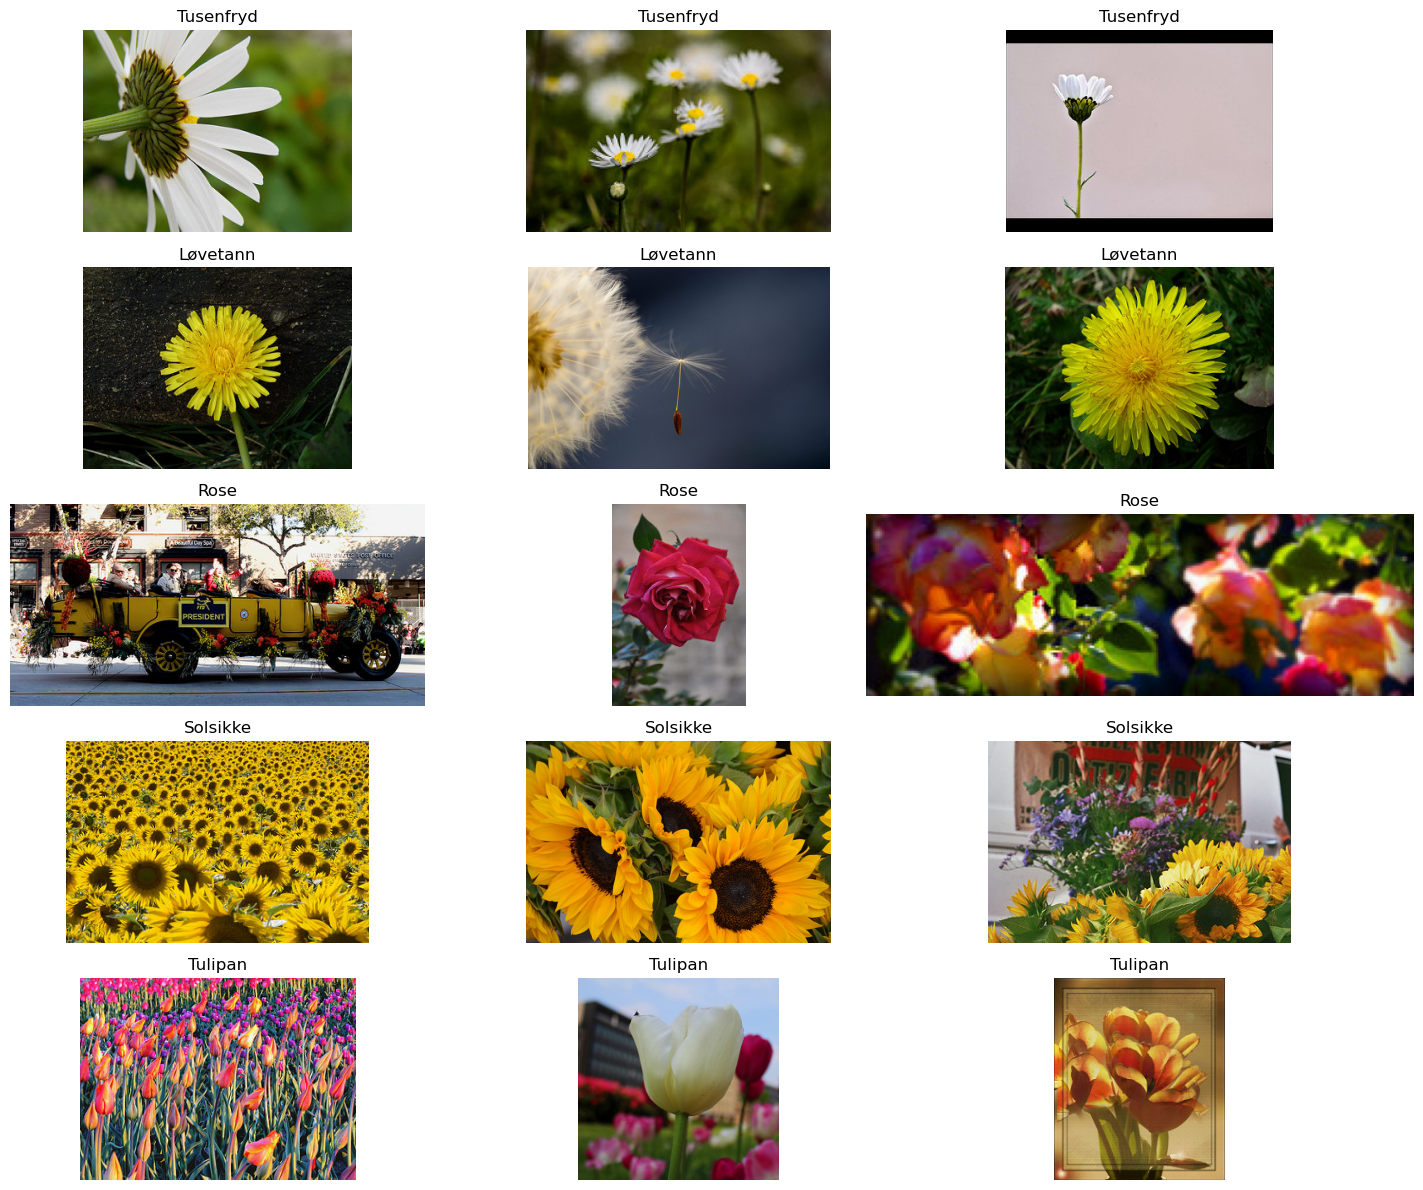

In [9]:
def show_flower_examples(data_dir='../data/flowers', num_examples=3):
    """Vis eksempler fra hver blomstertype"""
    
    if IN_COLAB:
        data_dir = 'data/flowers'
    
    data_path = Path(data_dir)
    
    if not data_path.exists():
        print(f"❌ Mappen {data_dir} finnes ikke!")
        return
    
    fig, axes = plt.subplots(num_classes, num_examples, figsize=(15, 12))
    
    for i, (class_name, class_idx) in enumerate(class_mapping.items()):
        class_dir = data_path / class_name
        
        if class_dir.exists():
            image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
            
            for j in range(min(num_examples, len(image_files))):
                if j < len(image_files):
                    img_path = image_files[j]
                    img = Image.open(img_path)
                    
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f"{class_names[class_idx]}")
                    axes[i, j].axis('off')
                else:
                    axes[i, j].axis('off')
        else:
            for j in range(num_examples):
                axes[i, j].text(0.5, 0.5, 'Ikke funnet', ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Vis eksempler
print("🌸 Eksempler fra hver blomstertype:")
show_flower_examples()

## �� Data Preprosessering

Før vi kan trene modellen, må vi forberede dataene. Dette inkluderer:
- **Normalisering** av pikselverdier
- **Dataaugmentering** for å øke variasjonen
- **Splitting** i trenings-, validerings- og testsett

In [10]:
# Definer transformasjoner
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Transformasjoner definert!")
print("\n�� Trenings-transformasjoner:")
print("- Resize til 224x224")
print("- Random horizontal flip")
print("- Random rotation (±15°)")
print("- Color jitter")
print("- Normalisering")

print("\n📋 Validerings-transformasjoner:")
print("- Resize til 224x224")
print("- Normalisering")
print("- Ingen dataaugmentering")

✅ Transformasjoner definert!

�� Trenings-transformasjoner:
- Resize til 224x224
- Random horizontal flip
- Random rotation (±15°)
- Color jitter
- Normalisering

📋 Validerings-transformasjoner:
- Resize til 224x224
- Normalisering
- Ingen dataaugmentering


In [11]:
# Custom Dataset klasse
class FlowerDataset(Dataset):
    """Custom dataset for blomsterbilder"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Last bilde
        image = Image.open(image_path).convert('RGB')
        
        # Anvend transform
        if self.transform:
            image = self.transform(image)
            
        return image, label

print("✅ FlowerDataset klasse definert!")

✅ FlowerDataset klasse definert!


In [12]:
def prepare_data(data_dir='../data/flowers'):
    """Forbered data for trening"""
    
    if IN_COLAB:
        data_dir = 'data/flowers'
    
    data_path = Path(data_dir)
    
    if not data_path.exists():
        print(f"❌ Mappen {data_dir} finnes ikke!")
        return None, None, None, None
    
    # Samle alle bilder og etiketter
    all_images = []
    all_labels = []
    
    for class_name, class_idx in class_mapping.items():
        class_dir = data_path / class_name
        
        if class_dir.exists():
            image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
            
            for img_path in image_files:
                all_images.append(str(img_path))
                all_labels.append(class_idx)
    
    if not all_images:
        print("❌ Ingen bilder funnet!")
        return None, None, None, None
    
    # Split i trenings-, validerings- og testsett
    X_train, X_temp, y_train, y_temp = train_test_split(
        all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"�� Data-splitting fullført:")
    print(f"  Treningssett: {len(X_train)} bilder")
    print(f"  Valideringssett: {len(X_val)} bilder")
    print(f"  Testsett: {len(X_test)} bilder")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), class_names

# Forbered data
train_data, val_data, test_data, class_names = prepare_data()

if train_data is not None:
    print("✅ Data forberedt for trening!")
else:
    print("❌ Kunne ikke forberede data")

�� Data-splitting fullført:
  Treningssett: 3021 bilder
  Valideringssett: 648 bilder
  Testsett: 648 bilder
✅ Data forberedt for trening!


In [13]:
# Opprett DataLoaders
if train_data is not None:
    X_train, y_train = train_data
    X_val, y_val = val_data
    X_test, y_test = test_data
    
    # Opprett datasets
    train_dataset = FlowerDataset(X_train, y_train, train_transform)
    val_dataset = FlowerDataset(X_val, y_val, val_transform)
    test_dataset = FlowerDataset(X_test, y_test, val_transform)
    
    # Opprett DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"✅ DataLoaders opprettet med batch_size={batch_size}")
    print(f"  Treningsbatcher: {len(train_loader)}")
    print(f"  Valideringsbatcher: {len(val_loader)}")
    print(f"  Testbatcher: {len(test_loader)}")
else:
    print("❌ Kunne ikke opprette DataLoaders")

✅ DataLoaders opprettet med batch_size=32
  Treningsbatcher: 95
  Valideringsbatcher: 21
  Testbatcher: 21


## 🏗️ CNN-arkitektur

Nå skal vi bygge vår CNN-modell. Vi starter med en enkel arkitektur og forklarer hver komponent.

In [14]:
class SimpleCNN(nn.Module):
    """Enkel CNN for blomsterklassifikasjon"""
    
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        
        # Konvolusjonslag
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels (RGB)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout for regularisering
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected lag
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # 224/2/2/2 = 28
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Konvolusjonsblokk 1
        x = self.pool(torch.relu(self.conv1(x)))  # 224x224 -> 112x112
        
        # Konvolusjonsblokk 2
        x = self.pool(torch.relu(self.conv2(x)))  # 112x112 -> 56x56
        
        # Konvolusjonsblokk 3
        x = self.pool(torch.relu(self.conv3(x)))  # 56x56 -> 28x28
        
        # Flatten for fully connected lag
        x = x.view(-1, 128 * 28 * 28)
        
        # Fully connected lag
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

print("✅ SimpleCNN klasse definert!")

✅ SimpleCNN klasse definert!


In [15]:
# Opprett modell
model = SimpleCNN(num_classes=num_classes)
model = model.to(device)

# Vis modellarkitektur
print("🏗️ Modellarkitektur:")
print("=" * 50)
print(model)

# Tell parametere
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n�� Parametere:")
print(f"  Totalt: {total_params:,}")
print(f"  Trenbare: {trainable_params:,}")
print(f"  Enhet: {device}")

🏗️ Modellarkitektur:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

�� Parametere:
  Totalt: 51,476,549
  Trenbare: 51,476,549
  Enhet: mps


### 🔍 Forklaring av CNN-komponenter

**Konvolusjonslag (Conv2d):**
- Detekterer mønstre som kanter, teksturer, former
- Hver filter lærer å gjenkjenne spesifikke trekk
- Første lag: 3 input channels (RGB) → 32 feature maps

**Pooling (MaxPool2d):**
- Reduserer bilde-størrelse
    - 224×224 → 112×112 → 56×56 → 28×28
- Beholder viktige trekk, reduserer støy
- Gjør modellen mer robust for små forskyvninger

**Aktiviseringsfunksjon (ReLU):**
- ReLU(x) = max(0, x)
- Introduserer ikke-linearitet
    - Uten ReLU ville modellen være lineær
- Hjelper med å lære komplekse mønstre

**Fully Connected lag:**
- Kombinerer alle trekk til en prediksjon
- fc1: 128×28×28 = 100,352 → 512
- fc2: 512 → 5 (antall klasser)

**Dropout:**
- Regularisering for å forhindre overfitting
- Slår tilfeldig ut 50% av neuronene under trening

## 💾 Lagring av modell og data

Før vi går videre til trening, lagrer vi modellen og dataene slik at de kan brukes i del 2.

In [16]:
# Lagre modellarkitektur og data
if train_data is not None:
    # Lagre modellarkitektur
    torch.save(model.state_dict(), 'flower_model_architecture.pth')
    
    # Lagre data-splitting
    import pickle
    data_info = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'class_names': class_names,
        'class_mapping': class_mapping,
        'num_classes': num_classes
    }
    
    with open('flower_data_info.pkl', 'wb') as f:
        pickle.dump(data_info, f)
    
    print("✅ Modell og data lagret for del 2!")
    print("📁 Filer opprettet:")
    print("  - flower_model_architecture.pth")
    print("  - flower_data_info.pkl")
else:
    print("❌ Kunne ikke lagre - ingen data tilgjengelig")

✅ Modell og data lagret for del 2!
📁 Filer opprettet:
  - flower_model_architecture.pth
  - flower_data_info.pkl


## �� Oppsummering og neste steg

### Hva vi har oppnådd:
- ✅ Satt opp miljøet (CPU/GPU/MPS)
- ✅ Lastet ned og utforsket blomsterdatasettet
- ✅ Forberedt data med transformasjoner og splitting
- ✅ Bygget en CNN-modell fra bunnen av
- ✅ Lagret modell og data for del 2

### Neste steg (del 2):
- 🚀 Trening av modellen
- �� Visualisering av treningsresultater
- �� Lagring av trent modell

### Refleksjonsspørsmål:
1. **Hvorfor** bruker vi konvolusjonslag i stedet for vanlige fully connected lag?
2. **Hvordan** påvirker dataaugmentering modellens ytelse?
3. **Hva** er fordelene med å splitte data i trenings-, validerings- og testsett?
4. **Hvorfor** er normalisering viktig for CNN-trening?

---

**Gå videre til del 2: `02b_cnn_trening.ipynb`**